# Explicit integration implementation

The Mohr-Coulomb material model is very commonly utilized in soil mechanics. It utilizes only the major and minor principal stresses, and ignores the intermediate principal stress. For simplicity, this code utilizes the MIT-based definitions of q and p. These definitions are not fundamental, and ignore the intermediate principal stress, which is known to influence soil plasticity. It is common in Mohr Coulomb modeling to add a constant dilation angle. This constitutes a non-associated flow rule because the plastic flow direction may or may not be normal to the yield surface.

### MIT-invariant definitions

$p_{MIT} = \cfrac{\sigma_1 + \sigma_3}{2}$  

$q_{MIT} = \cfrac{\sigma_1 - \sigma_3}{2}$  

$\varepsilon_{v,MIT} = \cfrac{\varepsilon_1 + \varepsilon_3}{2}$  

$\varepsilon_{q,MIT} = \cfrac{\varepsilon_1 - \varepsilon_3}{2}$  

### Yield Function  

$f(p_{MIT},q_{MIT},\phi) = q_{MIT} - p_{MIT} \cdot sin\phi - c \cdot cos\phi$  

$\phi$ = friction angle  

$c$ = cohesion

### Elasticity

Here we assume isotropic, pressure-independent elasticity, though other elasticity formulations could be adapted with the Mohr Coulomb yield surface.

$\dot{p} = K\dot{\varepsilon_v^e}$  

$\dot{q} = G\dot{\varepsilon_q^e}$  

$K$ = constant  

$G = \cfrac{3K\left(1+2\nu\right)}{2\left(1+\nu\right)}$  = constant 

### Flow Rule

Mohr Coulomb material models often include the ability to specify a constant dilation angle, $\psi$, that defines plastic volumetric strain rate as a function of plastic shear strain rate. Since this dilation angle is specified independent of the yield surface definition, this is a non-associated flow rule.

$\cfrac{\dot{\varepsilon}_v^p}{\dot{\varepsilon}_q^p} = -tan \psi$ (compression positive)

$\psi$ = dilation angle

### Hardening

We assume that no hardening occurs

$\dot{\phi}$ = 0  

$\dot{c}$ = 0  


# Undrained monotonic loading

For undrained loading, $\dot{\varepsilon}_v = 0$. So we just need to specify a vector of zeros for $\varepsilon_v$ and a vector of $\varepsilon_q$, and solve for the corresponding p and q at each time step.

<IPython.core.display.Javascript object>


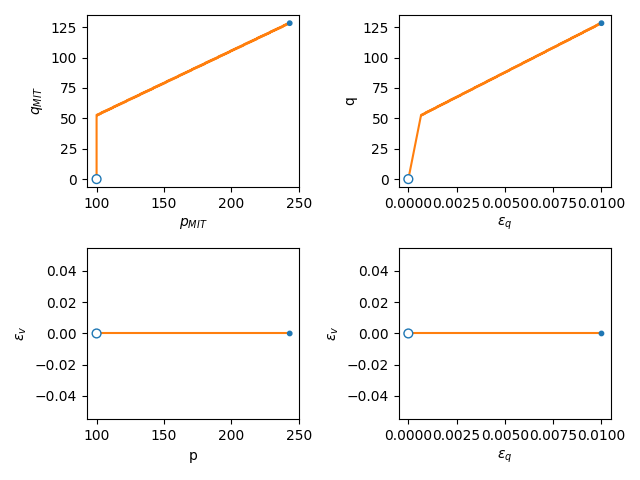

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Undrained monotonic stress path
N = 1000
eq_max = 0.01
eq = np.linspace(0,eq_max,N)
ev = np.zeros(N)

pc = np.zeros(N)
p = np.zeros(N)
q = np.zeros(N)
e = np.zeros(N)
ue = np.zeros(N)
p[0] = 100

nu = 0.3
phi = 32.0*np.pi/180.0
c = 0.0
VS = 200
rho = 2.0
G = rho*VS*VS
K = G*(1-nu)/(1+2*nu)
psi = 26.0*np.pi/180.0

for i in range(1,N):
    qtrial = q[i-1] + G*(eq[i]-eq[i-1])
    ptrial = p[i-1] + K*(ev[i]-ev[i-1])
    ftrial = qtrial - ptrial*np.sin(phi) - c*np.cos(phi)
    if(ftrial<0):
        p[i] = ptrial
        q[i] = qtrial
    else:
        gamma = (G*(eq[i]-eq[i-1]) + K*np.sin(phi)*(ev[i]-ev[i-1]))/(G - K*np.sin(phi)*np.tan(psi))
        q[i] = q[i-1] + G*(eq[i]-eq[i-1]-gamma)
        p[i] = p[i-1] + K*(ev[i]-ev[i-1]+gamma*np.tan(psi))

fig, ax = plt.subplots(2,2)
ax[0,0].plot(p,q,zorder=2,c='C1')
ax[0,0].scatter([p[0],p[-1]],[q[0],q[-1]],c=['white','C0'],s=[40,10],edgecolor='C0',zorder=3)
ax[0,1].plot(eq,q,c='C1')
ax[0,1].scatter([eq[0],eq[-1]],[q[0],q[-1]],c=['white','C0'],s=[40,10],edgecolor='C0',zorder=3)
ax[1,0].plot(p,ev,c='C1')
ax[1,0].scatter([p[0],p[-1]],[ev[0],ev[-1]],c=['white','C0'],s=[40,10],edgecolor='C0',zorder=3)
ax[1,1].plot(eq,ev,c='C1')
ax[1,1].scatter([eq[0],eq[-1]],[ev[0],ev[-1]],c=['white','C0'],s=[40,10],edgecolor='C0',zorder=3)
ax[0,0].set_ylabel(r'$q_{MIT}$')
ax[0,0].set_xlabel(r'$p_{MIT}$')
ax[1,0].set_ylabel(r'$\varepsilon_v$')
ax[1,0].set_xlabel('p')
ax[0,1].set_ylabel('q')
ax[0,1].set_xlabel(r'$\varepsilon_q$')
ax[1,1].set_ylabel(r'$\varepsilon_v$')
ax[1,1].set_xlabel(r'$\varepsilon_q$')
ax[0,1].sharey(ax[0,0])
plt.tight_layout()

# Drained monotonic loading

Drained loading conditions are a bit more complicated to implement than undrained because we are dealing with mixed boundary conditions. We assume that shear is strain controlled such that we know $\varepsilon_q$ and that:

$\dot{p} = \alpha \cdot \dot{q}$

where $\alpha$ is a parameter defining stress path. For example, $\alpha = 0$ for a direct simple shear stress path, and $\alpha = 1/3$ for a triaxial compression stress path.